In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk(
    '/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/rossmann-store-sales/sample_submission.csv
/kaggle/input/rossmann-store-sales/store.csv
/kaggle/input/rossmann-store-sales/train.csv
/kaggle/input/rossmann-store-sales/test.csv


In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
import joblib


train = pd.read_csv('/kaggle/input/rossmann-store-sales/train.csv', low_memory=False)
store = pd.read_csv('/kaggle/input/rossmann-store-sales/store.csv', low_memory=False)
data = pd.merge(train, store, on='Store', how='left')


data['Date'] = pd.to_datetime(data['Date'])
data['Year'] = data['Date'].dt.year
data['Month'] = data['Date'].dt.month
data['Day'] = data['Date'].dt.day
data['WeekOfYear'] = data['Date'].dt.isocalendar().week


data.fillna(0, inplace=True)


le = LabelEncoder()
data['StoreType'] = le.fit_transform(data['StoreType'])
data['Assortment'] = le.fit_transform(data['Assortment'])
data['PromoInterval'] = le.fit_transform(data['PromoInterval'].astype(str))


X = data.drop(['Sales', 'Date'], axis=1)
y = data['Sales']


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


X_train = pd.get_dummies(X_train, columns=['StateHoliday'], drop_first=True)
X_test = pd.get_dummies(X_test, columns=['StateHoliday'], drop_first=True)
X_test = X_test.reindex(columns=X_train.columns, fill_value=0)


scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


X_train_tensor = torch.FloatTensor(X_train_scaled)
y_train_tensor = torch.FloatTensor(y_train.values).view(-1, 1)
X_test_tensor = torch.FloatTensor(X_test_scaled)


train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)




In [5]:
class MLP(nn.Module):
    def __init__(self, input_size):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(input_size, 128)
        self.fc2 = nn.Linear(128, 64)
        self.dropout = nn.Dropout(0.1)
        self.fc3 = nn.Linear(64, 1)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.dropout(self.relu(self.fc2(x)))
        return self.fc3(x)


from sklearn.model_selection import train_test_split
X_train_final, X_val, y_train_final, y_val = train_test_split(X_train_tensor, y_train_tensor, test_size=0.1, random_state=42)

train_dataset = TensorDataset(X_train_final, y_train_final)
val_dataset = TensorDataset(X_val, y_val)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=128, shuffle=False)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")



input_size = X_train_tensor.shape[1]
model = MLP(input_size).to(device)


criterion = nn.SmoothL1Loss()  # Huber Loss
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=5, factor=0.5)


best_val_loss = float('inf')
early_stop_counter = 0
early_stop_patience = 10


for epoch in range(1, 500):
    model.train()
    train_losses = []
    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)
        optimizer.zero_grad()
        out = model(xb)
        loss = criterion(out, yb)
        loss.backward()
        optimizer.step()
        train_losses.append(loss.item())

 
    model.eval()
    val_preds, val_targets = [], []
    with torch.no_grad():
        for xb, yb in val_loader:
            xb = xb.to(device)
            preds = model(xb).cpu().numpy()
            val_preds.extend(preds.flatten())
            val_targets.extend(yb.numpy().flatten())

    val_mse = mean_squared_error(val_targets, val_preds)
    val_rmse = np.sqrt(val_mse)
    val_r2 = r2_score(val_targets, val_preds)

    print(f"Epoch {epoch}, Train Loss: {np.mean(train_losses):.2f}, Val RMSE: {val_rmse:.2f}, R²: {val_r2:.4f}")

    scheduler.step(val_mse)


    if val_mse < best_val_loss:
        best_val_loss = val_mse
        early_stop_counter = 0
        best_model_state = model.state_dict()
    else:
        early_stop_counter += 1
        if early_stop_counter >= early_stop_patience:
            print("Early stopping triggered.")
            break


model.load_state_dict(best_model_state)


model.eval()
with torch.no_grad():
    test_preds = model(X_test_tensor.to(device)).cpu().numpy().flatten()
    mse = mean_squared_error(y_test, test_preds)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_test, test_preds)
    r2 = r2_score(y_test, test_preds)

print(f"\n MLP Final Evaluation -> MSE: {mse:.2f}, RMSE: {rmse:.2f}, MAE: {mae:.2f}, R^2: {r2:.4f}")


Epoch 1, Train Loss: 980.90, Val RMSE: 1225.17, R²: 0.8990
Epoch 2, Train Loss: 763.52, Val RMSE: 1130.13, R²: 0.9141
Epoch 3, Train Loss: 729.61, Val RMSE: 1082.05, R²: 0.9212
Epoch 4, Train Loss: 712.48, Val RMSE: 1048.45, R²: 0.9261
Epoch 5, Train Loss: 698.25, Val RMSE: 1015.02, R²: 0.9307
Epoch 6, Train Loss: 684.95, Val RMSE: 993.56, R²: 0.9336
Epoch 7, Train Loss: 672.69, Val RMSE: 968.60, R²: 0.9369
Epoch 8, Train Loss: 660.49, Val RMSE: 938.65, R²: 0.9407
Epoch 9, Train Loss: 649.65, Val RMSE: 921.07, R²: 0.9429
Epoch 10, Train Loss: 638.39, Val RMSE: 898.08, R²: 0.9457
Epoch 11, Train Loss: 628.13, Val RMSE: 885.73, R²: 0.9472
Epoch 12, Train Loss: 620.71, Val RMSE: 873.67, R²: 0.9487
Epoch 13, Train Loss: 613.59, Val RMSE: 856.91, R²: 0.9506
Epoch 14, Train Loss: 604.08, Val RMSE: 840.56, R²: 0.9525
Epoch 15, Train Loss: 597.64, Val RMSE: 828.68, R²: 0.9538
Epoch 16, Train Loss: 592.65, Val RMSE: 820.26, R²: 0.9547
Epoch 17, Train Loss: 586.21, Val RMSE: 805.21, R²: 0.9564
E

In [6]:
from sklearn.linear_model import LinearRegression

lr_model = LinearRegression()
lr_model.fit(X_train_scaled, y_train)

lr_preds = lr_model.predict(X_test_scaled)

lr_mse = mean_squared_error(y_test, lr_preds)
lr_rmse = np.sqrt(lr_mse)
lr_mae = mean_absolute_error(y_test, lr_preds)
lr_r2 = r2_score(y_test, lr_preds)

print(f"\n Linear Regression Evaluation -> MSE: {lr_mse:.2f}, RMSE: {lr_rmse:.2f}, MAE: {lr_mae:.2f}, R^2: {lr_r2:.4f}")



 Linear Regression Evaluation -> MSE: 1958411.33, RMSE: 1399.43, MAE: 943.12, R^2: 0.8676


In [7]:
from sklearn.ensemble import RandomForestRegressor

rf_model = RandomForestRegressor(n_estimators=20, random_state=42, n_jobs=-1)
rf_model.fit(X_train_scaled, y_train)

rf_preds = rf_model.predict(X_test_scaled)

rf_mse = mean_squared_error(y_test, rf_preds)
rf_rmse = np.sqrt(rf_mse)
rf_mae = mean_absolute_error(y_test, rf_preds)
rf_r2 = r2_score(y_test, rf_preds)

print(f"\n Random Forest Evaluation -> MSE: {rf_mse:.2f}, RMSE: {rf_rmse:.2f}, MAE: {rf_mae:.2f}, R^2: {rf_r2:.4f}")



 Random Forest Evaluation -> MSE: 205305.02, RMSE: 453.11, MAE: 271.13, R^2: 0.9861


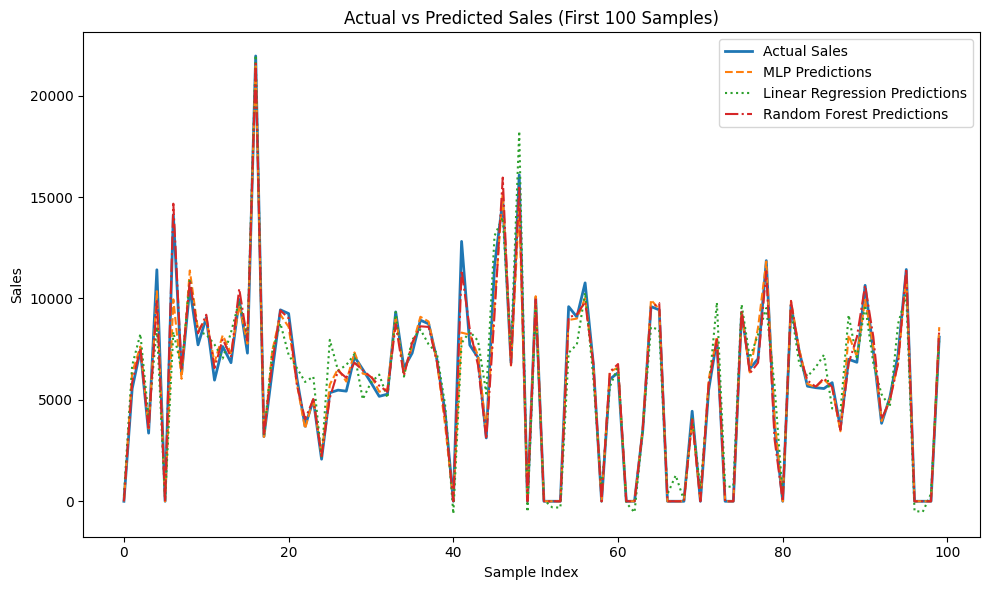

In [8]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(y_test.values[:100], label='Actual Sales', linewidth=2)
plt.plot(test_preds[:100], label='MLP Predictions', linestyle='--')
plt.plot(lr_preds[:100], label='Linear Regression Predictions', linestyle=':')
plt.plot(rf_preds[:100], label='Random Forest Predictions', linestyle='-.')
plt.xlabel('Sample Index')
plt.ylabel('Sales')
plt.title('Actual vs Predicted Sales (First 100 Samples)')
plt.legend()
plt.tight_layout()
plt.show()


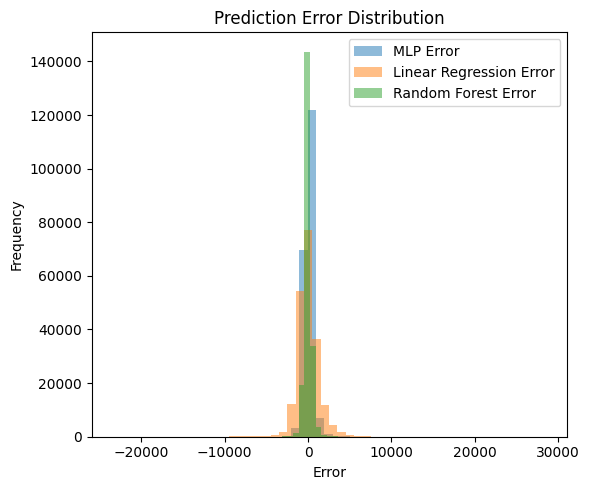

In [9]:
plt.figure(figsize=(6, 5))
plt.hist(y_test.values - test_preds, bins=50, alpha=0.5, label='MLP Error')
plt.hist(y_test.values - lr_preds, bins=50, alpha=0.5, label='Linear Regression Error')
plt.hist(y_test.values - rf_preds, bins=50, alpha=0.5, label='Random Forest Error')
plt.title('Prediction Error Distribution')
plt.xlabel('Error')
plt.ylabel('Frequency')
plt.legend()
plt.tight_layout()
plt.show()



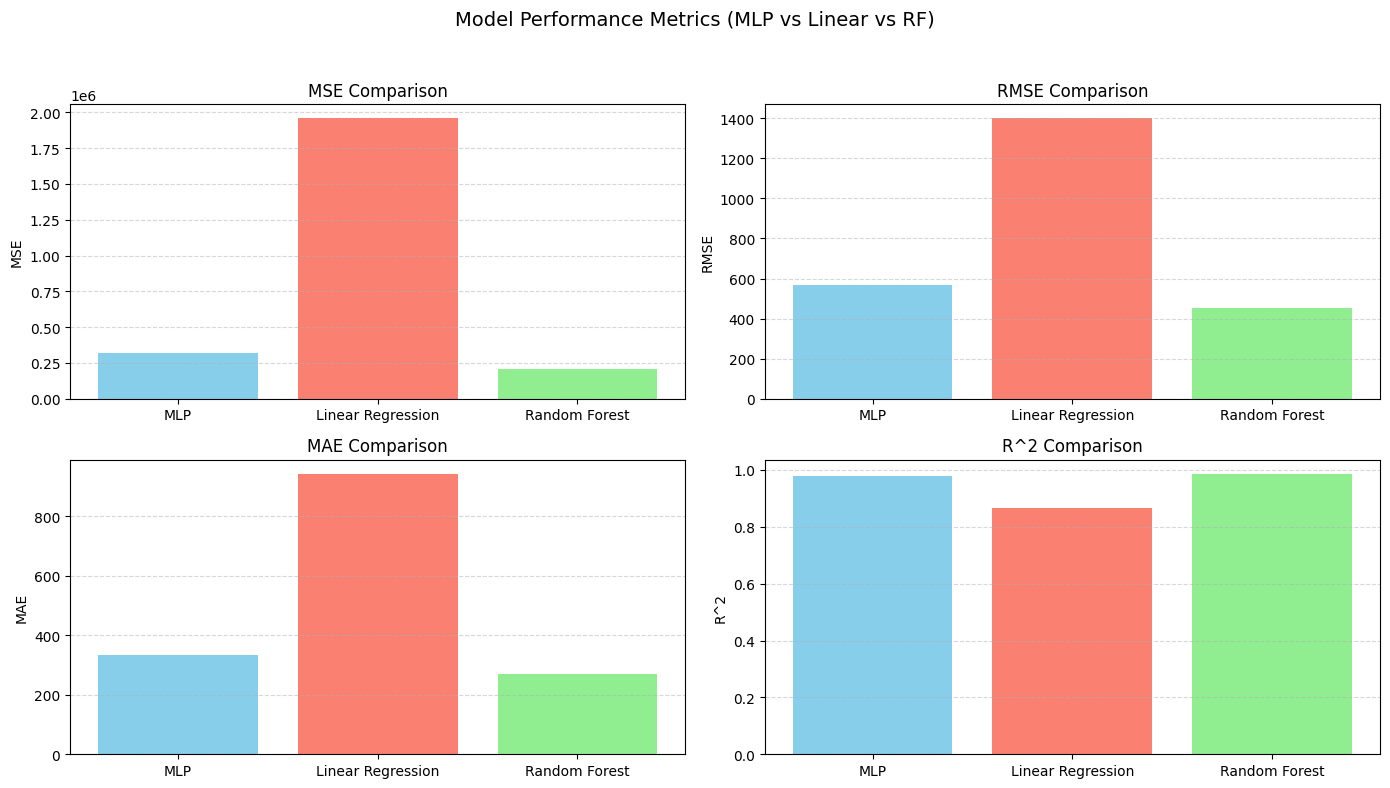

In [10]:
import matplotlib.pyplot as plt
import numpy as np


metrics = ['MSE', 'RMSE', 'MAE', 'R^2']
mlp_scores = [mse, rmse, mae, r2]
lr_scores = [lr_mse, lr_rmse, lr_mae, lr_r2]
rf_scores = [rf_mse, rf_rmse, rf_mae, rf_r2]

fig, axes = plt.subplots(2, 2, figsize=(14, 8))
axes = axes.flatten()

for i, metric in enumerate(metrics):
    axes[i].bar(['MLP', 'Linear Regression', 'Random Forest'],
                [mlp_scores[i], lr_scores[i], rf_scores[i]],
                color=['skyblue', 'salmon', 'lightgreen'])
    axes[i].set_title(f'{metric} Comparison')
    axes[i].set_ylabel(metric)
    axes[i].set_ylim(bottom=0)
    axes[i].grid(axis='y', linestyle='--', alpha=0.5)

plt.suptitle('Model Performance Metrics (MLP vs Linear vs RF)', fontsize=14)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


In [ ]:
# save
torch.save(model.state_dict(), 'mlp_model.pth')


import joblib
import json
with open('input_columns.json', 'w') as f:
    json.dump(X_train.columns.tolist(), f)


In [6]:

import pickle
with open("scaler2.pkl", "wb") as f:
    pickle.dump(scaler, f)